In [1]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import spacy
from datetime import datetime
import re
import string
from collections import Counter
import itertools
import networkx as nx
import unicodedata
import random
from gensim import corpora

### Sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Load Twitter data

In [3]:
df = pd.read_csv("/content/rdatascience_submission_comments_df.csv", index_col=[0])
df['body'] = df['body'].astype('str')
df['body']

0                           I think it’s just a bad time.
1       I’m on the hunt as well atm but with 3 YOE and...
2       Data engineering is not really a natural progr...
3       If you haven't yet check out r/dataengineering...
4       Contractor at FAANg is definitely not somethin...
                              ...                        
1136    In most cases, the company extends these offer...
1137    I wanna hear more about the consultant route o...
1138    My thought process was if a company is willing...
1139                                             Yea sure
1140    An intern is temporary. A minor waste of resou...
Name: body, Length: 1141, dtype: object

In [4]:
df = df[~df.body.isna()]

### Preprocessing Twitter Data

In [5]:
# remove HTML links and special characters
# choose functions that suit your neeeds

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ' ')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [7]:
def process_posts(post):
    post = strip_links(post)
    post = remove_special_characters(post)
    return post

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
df.loc[:, 'body'] = df.body.apply(process_posts)
df.body

0                             I think its just a bad time
1       Im on the hunt as well atm but with 3 YOE and ...
2       Data engineering is not really a natural progr...
3       If you havent yet check out rdataengineering\n...
4       Contractor at FAANg is definitely not somethin...
                              ...                        
1136    In most cases the company extends these offers...
1137    I wanna hear more about the consultant route o...
1138    My thought process was if a company is willing...
1139                                             Yea sure
1140    An intern is temporary A minor waste of resour...
Name: body, Length: 1141, dtype: object

### Stemming/Lemming

In [10]:
# Stemming / Lemming

### loading a spacy language model
# python -m spacy download en_core_web_sm
# https://spacy.io/models/en

nlp = spacy.load('en_core_web_sm')

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [11]:
print(post)
print('------\nstemmed post:')
print(simple_stemmer(post))
print('------\nlemmatized post:')
print(lemmatize_text(post))

Yes, the potential is the concern. You remind me of an interesting point. I am less worried about what the government is doing with the data is has than I am worried about how suddenly interested the US federal government is at buying your data from brokers all of a sudden. I was surprised, given they nearly passed legislation preventing themselves from purchasing data on citizens. But currently, specifically health data is what they are looking to buy. (The CDC’s data is nearly all secondary. It comes from state/local jurisdictions. They got pushed on by congress for not having more data for them during COVID, argued they states weren’t playing ball, and providing enough data fast enough, so now they’re looking to circumvent the system.) This to me is scary—the idea of the government is quietly buying data you don’t know they have is not okay. It’s “deidentified” but they want granular enough data that it’s hardly relevant given all the other data they have.
------
stemmed post:
yes, 

### Tokenizing and Corpus Creation

In [12]:
### Run this the first time
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [14]:
%%time
#Create corupus of all words
words_corpus = []
for elem in df.body:
    # remove stop words
    elem = remove_stopwords(elem)
    # lemmatize text
    elem = lemmatize_text(elem)
    words_corpus.append(elem.lower().split())
print(len(words_corpus))

dictionary = corpora.Dictionary(words_corpus)
print(len(dictionary))

1141
4855
CPU times: user 14 s, sys: 61.3 ms, total: 14 s
Wall time: 14.8 s


#### Apply this to the entire dataframe

In [15]:
%%time
df["text_processed"] = df.body.apply(remove_stopwords)
df["text_processed"] = df.text_processed.apply(lemmatize_text)
df["text_processed"] = df.text_processed.apply(lambda x: x.lower().split())

CPU times: user 12.8 s, sys: 53.4 ms, total: 12.8 s
Wall time: 14.3 s


# RUN UNTIL HERE TO FOLLOW DURING CLASS

In [23]:
df["text_tups"] = df.text_processed.apply(lambda x: list(itertools.combinations(x, 2)))
all_tups = [item for sublist in df.text_tups.values for item in sublist]
all_tups = Counter(all_tups)

In [40]:
word_edges = all_tups.most_common(100)
word_edges = [(w[0][0], w[0][1], w[1] ) for w in word_edges]

In [41]:
G = nx.Graph()
G.add_weighted_edges_from(word_edges)

In [42]:
G.remove_edges_from(nx.selfloop_edges(G))

In [43]:
connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
largest_component = connected_components[0]
G = G.subgraph(largest_component)

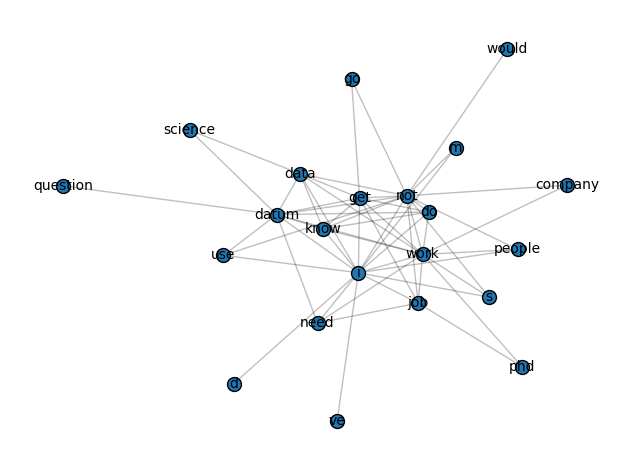

In [45]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, seed=200)
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1)
nx.draw_networkx_nodes(G, pos, node_size=100).set_edgecolor('black')

# Add labels to the nodes
labels = {node: str(node) for node in G.nodes()}  # Replace str(node) with your actual labels
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

plt.tight_layout()
plt.axis("off")
plt.show()

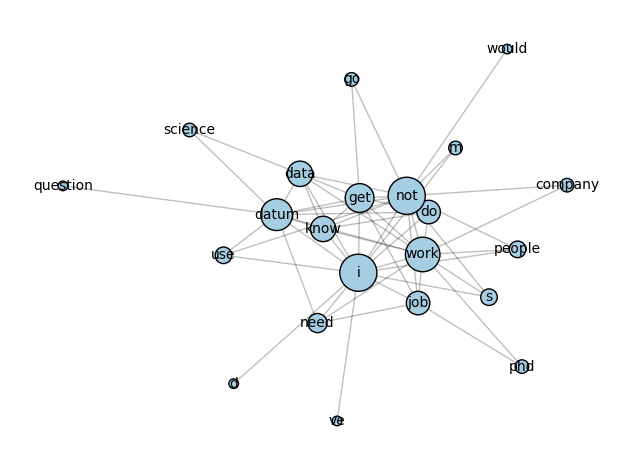

In [44]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
scaled_degree_centrality = {node: deg * 1000 for node, deg in degree_centrality.items()}  # Scale it up for visualization

# Lighter node colors
node_colors = ['#a6cee3' for _ in G.nodes()]

# Node positions
pos = nx.spring_layout(G, seed=200)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1)

# Draw nodes with lighter colors and scaled sizes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=list(scaled_degree_centrality.values())).set_edgecolor('black')

# Add standout labels to the nodes
labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

# Show the graph
plt.tight_layout()
plt.axis("off")
plt.show()

## LDA Topic Modeling & Visualization

In [46]:
words_corpus1 = df["text_processed"].values

In [47]:
dictionary = corpora.Dictionary(words_corpus)
dictionary.filter_extremes(no_below=5, no_above=0.2, keep_n=10000)

corpus_bow = [dictionary.doc2bow(text) for text in words_corpus]

# Term Frequency - Inverse Document Frequency

from gensim import corpora, models

# https://radimrehurek.com/gensim/models/ldamodel.html

tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

In [48]:
%%time
# Only 5 topics this time for simplicity
num_topics = 5
lda_model_tfidf = models.LdaMulticore(corpus_tfidf, num_topics=num_topics,
                                      id2word=dictionary, passes=4, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.006*"op" + 0.006*"use" + 0.006*"s" + 0.005*"like" + 0.005*"ask" + 0.005*"go" + 0.005*"work" + 0.005*"yeah" + 0.005*"sql" + 0.005*"author"
Topic: 1 Word: 0.011*"]" + 0.011*"[" + 0.009*"python" + 0.007*"use" + 0.007*"excel" + 0.007*"datum" + 0.006*"time" + 0.006*"comment" + 0.005*"i" + 0.005*"would"
Topic: 2 Word: 0.008*"think" + 0.006*"mean" + 0.006*"job" + 0.006*"people" + 0.006*"work" + 0.006*"experience" + 0.005*"you" + 0.005*"i" + 0.005*"need" + 0.005*"de"
Topic: 3 Word: 0.008*"i" + 0.007*"datum" + 0.007*"job" + 0.007*"data" + 0.006*"science" + 0.006*"think" + 0.006*"m" + 0.005*"re" + 0.005*"like" + 0.005*"you"
Topic: 4 Word: 0.011*"thank" + 0.007*"year" + 0.007*"work" + 0.005*"get" + 0.005*"datum" + 0.005*"model" + 0.005*"go" + 0.005*"use" + 0.005*"i" + 0.005*"job"
CPU times: user 4.54 s, sys: 318 ms, total: 4.85 s
Wall time: 5.82 s


In [49]:
!pip install pyLDAvis==2.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97718 sha256=d7479b1d070172c35db301985fa334e77bbef9069355d4adad2946210f5f259d
  Stored in directory: /root/.cache/pip/wheels/d9/93/d6/16c95da19c32f037fd75135ea152d0df37254c25cd1a8b4b6c
Successfully built pyLDAvis


In [50]:
import pyLDAvis
import pyLDAvis.gensim

In [51]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.038992 -0.011872       1        1  32.579922
0     -0.062366  0.026676       2        1  19.253505
2      0.031647  0.041514       3        1  17.992361
4      0.007588 -0.003432       4        1  16.299404
1     -0.015861 -0.052886       5        1  13.874809, topic_info=        Term       Freq      Total Category  logprob  loglift
512        ]   7.000000   7.000000  Default  30.0000  30.0000
511        [   7.000000   7.000000  Default  29.0000  29.0000
360    thank  13.000000  13.000000  Default  28.0000  28.0000
308   python  11.000000  11.000000  Default  27.0000  27.0000
939    excel   9.000000   9.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
386  problem   1.759368   9.534122   Topic5  -5.7367   0.2852
34       job   1.958593  19.803117   Topic5  -5.6295  -0.3385
334       op   1.691885   7.681709   Topic5  -5.7759   0.4621
12         m   1.743251  16.268863   Topic5  -5.7459  -0.2584
239     much   1.704420  10.281224   Topic5  -5.7685   0.1780

[344 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
221       1  0.261813     1
221       2  0.392720     1
221       3  0.130907     1
221       4  0.130907     1
221       5  0.130907     1
...     ...       ...   ...
137       3  0.256735   you
137       4  0.128367   you
137       5  0.064184   you
138       1  0.349198  zero
138       2  0.698396  zero

[674 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 5, 2])